## Section-1: Loading the dataset and preliminary exploration of the dataset

**1.1 Importing Required libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import time
from sklearn.metrics import mean_squared_error

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

**1.2 Loading the data and preliminary study of the data**

In [ ]:
#Load your data into a pandas dataframe here
df = pd.read_csv("IoTProcessed_Data.csv", delimiter = ",")


In [ ]:
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37922 entries, 0 to 37921
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     37920 non-null  object 
 1   tempreature              37922 non-null  int64  
 2   humidity                 37922 non-null  int64  
 3   water_level              37922 non-null  int64  
 4   N                        37922 non-null  int64  
 5   P                        37922 non-null  int64  
 6   K                        37922 non-null  int64  
 7   Fan_actuator_OFF         37922 non-null  float64
 8   Fan_actuator_ON          37922 non-null  float64
 9   Watering_plant_pump_OFF  37922 non-null  float64
 10  Watering_plant_pump_ON   37922 non-null  float64
 11  Water_pump_actuator_OFF  37922 non-null  float64
 12  Water_pump_actuator_ON   37922 non-null  float64
dtypes: float64(6), int64(6), object(1)
memory usage: 3.8+ MB
None
              

**1.3 Creating a copy of the original dataframe for further working**

In [ ]:
df_modified = df.copy()

**1.4 Creating another column for UNix date and time**

In [ ]:
# First, convert the 'date' column to datetime format

df_modified['date'] = pd.to_datetime(df_modified['date'], errors='coerce')

# Convert the datetime to Unix timestamp (in seconds)
df_modified['unix_timestamp'] = df_modified['date'].astype('int64') // 10**9

# Display the first few rows to verify
print(df_modified[['date', 'unix_timestamp']].head())


                 date  unix_timestamp
0 2024-02-08 06:10:00      1707372600
1 2024-02-08 06:15:00      1707372900
2 2024-02-08 06:20:00      1707373200
3 2024-02-08 06:05:00      1707372300
4 2024-02-08 06:00:00      1707372000


**1.5 Exploring inconcisties in the time feature:**

***1.5.1 Finding the mode of the time difference for the most common time difference***

In [ ]:
# Calculate the time difference between consecutive rows
time_differences = df_modified['unix_timestamp'].diff()

# Display the unique time differences
print("Unique time differences (in seconds):")
print(time_differences.unique())

# Check the most common time difference
print("Most common time difference (mode):")
print(time_differences.mode()[0], "seconds")


Unique time differences (in seconds):
[         nan  3.00000e+02 -9.00000e+02 ... -2.25378e+06  1.98078e+06
 -2.16408e+06]
Most common time difference (mode):
300.0 seconds


***1.5.2 Checking the other time differences counts***

In [ ]:
# Sort the DataFrame by date
df_modified = df_modified.sort_values(by='unix_timestamp').reset_index(drop=True)

# Recalculate time difference after sorting
df_modified['time_difference_seconds'] = df_modified['unix_timestamp'].diff()

# Convert to minutes for readability
df_modified['time_difference_minutes'] = df_modified['time_difference_seconds'] / 60

# Group and count occurrences
time_diff_counts = df_modified['time_difference_minutes'].value_counts().sort_index()

# Display the time differences and their counts
print(time_diff_counts)


time_difference_minutes
0.00000             9239
1.00000             3511
2.00000              420
3.00000              218
4.00000              385
5.00000            23815
6.00000              214
7.00000                3
8.00000                7
9.00000                2
10.00000              44
11.00000               1
12.00000               3
13.00000               3
15.00000              12
20.00000               3
21.00000               2
22.00000               1
28.00000               1
30.00000               3
34.00000               1
37.00000               1
45.00000               1
46.00000               1
47.00000               2
55.00000               2
56.00000               1
65.00000               1
66.00000               1
79.00000               1
80.00000               1
84.00000               1
90.00000               2
129.00000              1
170.00000              1
225.00000              1
247.00000              1
460.00000              1
470.00000              1
4

***1.5.3 Finding if there is a negative time difference***

In [ ]:
# Identify negative time differences
negative_diffs = df_modified[df_modified['time_difference_minutes'] < 0]

# Display negative time differences for investigation
print(negative_diffs[['date', 'unix_timestamp', 'time_difference_minutes']])


Empty DataFrame
Columns: [date, unix_timestamp, time_difference_minutes]
Index: []


***1.5.4 Finding commmon time difference counts***

In [ ]:
# Filter to show time differences that occur more than once
common_time_diffs = time_diff_counts[time_diff_counts > 1]

# Display common time differences
print(common_time_diffs)


time_difference_minutes
0.00000      9239
1.00000      3511
2.00000       420
3.00000       218
4.00000       385
5.00000     23815
6.00000       214
7.00000         3
8.00000         7
9.00000         2
10.00000       44
12.00000        3
13.00000        3
15.00000       12
20.00000        3
21.00000        2
30.00000        3
47.00000        2
55.00000        2
90.00000        2
Name: count, dtype: int64


Interpretation:
High Counts at Specific Intervals:

- 0 minutes (9,239 occurrences): Likely indicates duplicate timestamps or events logged at the exact same time.
- 1 minute (3,511 occurrences) and
- 5 minutes (23,815 occurrences):

Suggest regular logging intervals, possibly from automated systems or sensors.

Sparse Counts at Irregular Intervals:

Time differences like 7, 9, 13, 47, 55, 90 minutes are irregular and may indicate anomalies, missing data, or irregular logging.

***1.5.5 Exploring duplicate time differences***

In [ ]:
# Find records with duplicate timestamps
duplicate_timestamps = df_modified[df_modified['time_difference_minutes'] == 0]

# Display sample of duplicate records
print(duplicate_timestamps[['date', 'unix_timestamp']].head(10))


                    date  unix_timestamp
1                    NaT     -9223372037
453  2023-11-28 20:14:00      1701202440
1164 2023-12-01 07:08:00      1701414480
1437 2023-12-02 05:38:00      1701495480
1438 2023-12-02 05:38:00      1701495480
1629 2023-12-02 21:03:00      1701550980
1630 2023-12-02 21:03:00      1701550980
1642 2023-12-02 21:32:00      1701552720
1644 2023-12-02 21:33:00      1701552780
1653 2023-12-02 21:45:00      1701553500


***1.5.6 Finding irregular time differnces > 6 minutes*** *(as the most common time difference was 5 minutes)*

In [ ]:
# Filter irregular time gaps (greater than 6 minutes)
irregular_gaps = df_modified[df_modified['time_difference_minutes'] > 6]

# Display sample of irregular gaps
print(irregular_gaps[['date', 'unix_timestamp', 'time_difference_minutes']].head(10))


                    date  unix_timestamp  time_difference_minutes
2    2023-11-27 06:26:00      1701066360          182073973.28333
221  2023-11-28 00:46:00      1701132360                 10.00000
367  2023-11-28 13:01:00      1701176460                 11.00000
392  2023-11-28 15:09:00      1701184140                  9.00000
452  2023-11-28 20:14:00      1701202440                 10.00000
522  2023-11-29 02:04:00      1701223440                 10.00000
1361 2023-12-01 23:58:00      1701475080                 30.00000
1698 2023-12-03 01:34:00      1701567240                 10.00000
1837 2023-12-03 12:39:00      1701607140                 30.00000
1840 2023-12-03 13:09:00      1701608940                 20.00000


***1.5.7 Finding largest time differences***

In [ ]:
# Find the top 5 longest time gaps
longest_gaps = df_modified.nlargest(5, 'time_difference_minutes')

# Display longest gaps with context
print(longest_gaps[['date', 'unix_timestamp', 'time_difference_minutes']])


                     date  unix_timestamp  time_difference_minutes
2     2023-11-27 06:26:00      1701066360          182073973.28333
37867 2024-03-11 06:35:00      1710138900              15883.00000
37883 2024-03-23 07:51:00      1711180260              10469.00000
37888 2024-03-27 06:35:00      1711521300               5681.00000
37871 2024-03-14 06:47:00      1710398820               4330.00000


Key Observations:

1. Extreme Outliers:

- NaT and -9223372037: This is an invalid date, likely due to corrupted data or conversion errors.
- Large Time Gaps (e.g., 182,073,973 minutes ~345 years): Indicates serious data anomalies, possibly from incorrect timestamps.


2. Duplicate Timestamps:

- Identical timestamps (2023-12-02 05:38:00 and 2023-12-02 21:03:00), suggesting either:
    - Legitimate repeated events.
    - Redundant data that may need deduplication.

3. Regular Intervals with Irregular Spikes:

Most data falls into regular intervals (1, 5 minutes), with occasional unexpected larger gaps.

**1.6 Handling inconsistencies in time feature**

***1.6.1 Handle Invalid Dates (NaT and Extreme Timestamps)***

In [ ]:
# Remove rows with NaT in the date column
df_modified = df_modified[df_modified['date'].notna()]

# Filter out extremely large negative or unrealistic timestamps
df_modified = df_modified[(df_modified['unix_timestamp'] > 0) & (df_modified['unix_timestamp'] < 2000000000)]

# Verify if invalid data has been removed
print(df_modified[['date', 'unix_timestamp']].head())


                 date  unix_timestamp
2 2023-11-27 06:26:00      1701066360
3 2023-11-27 06:31:00      1701066660
4 2023-11-27 06:36:00      1701066960
5 2023-11-27 06:41:00      1701067260
6 2023-11-27 06:46:00      1701067560


***1.6.2. Addressing Duplicate Timestamps***

In [ ]:
# Remove duplicate timestamps (keeping the first occurrence)
df_modified = df_modified.drop_duplicates(subset=['unix_timestamp'], keep='first')


***1.6.3 Recalculate Time difference***

In [ ]:
# Recalculate time differences after cleaning
df_modified = df_modified.sort_values(by='unix_timestamp').reset_index(drop=True)
df_modified['time_difference_minutes'] = df_modified['unix_timestamp'].diff() / 60

# Review time differences again
time_diff_counts = df_modified['time_difference_minutes'].value_counts().sort_index()
print(time_diff_counts)


time_difference_minutes
1.00000         3511
2.00000          420
3.00000          218
4.00000          385
5.00000        23815
6.00000          214
7.00000            3
8.00000            7
9.00000            2
10.00000          44
11.00000           1
12.00000           3
13.00000           3
15.00000          12
20.00000           3
21.00000           2
22.00000           1
28.00000           1
30.00000           3
34.00000           1
37.00000           1
45.00000           1
46.00000           1
47.00000           2
55.00000           2
56.00000           1
65.00000           1
66.00000           1
79.00000           1
80.00000           1
84.00000           1
90.00000           2
129.00000          1
170.00000          1
225.00000          1
247.00000          1
460.00000          1
470.00000          1
471.00000          1
540.00000          1
1236.00000         1
1454.00000         1
1542.00000         1
2547.00000         1
3721.00000         1
4330.00000         1
5681.00000

***1.6.3 Investigating remaining irregularities***

In [ ]:
# Check for gaps greater than a threshold (e.g., 60 minutes)
irregular_gaps = df_modified[df_modified['time_difference_minutes'] > 60]
print(irregular_gaps[['date', 'unix_timestamp', 'time_difference_minutes']])


                     date  unix_timestamp  time_difference_minutes
2388  2023-12-05 23:04:00      1701817440                460.00000
2766  2023-12-07 07:53:00      1701935580                 66.00000
2933  2023-12-07 23:27:00      1701991620                170.00000
3305  2023-12-11 07:13:00      1702278780               3721.00000
3855  2023-12-12 17:12:00      1702401120                 79.00000
3919  2023-12-12 19:53:00      1702410780                 90.00000
3920  2023-12-12 21:23:00      1702416180                 90.00000
3940  2023-12-12 23:48:00      1702424880                 65.00000
4185  2023-12-13 23:48:00      1702511280                225.00000
5549  2023-12-19 01:12:00      1702948320                470.00000
5717  2023-12-19 18:02:00      1703008920                 80.00000
5724  2023-12-19 22:32:00      1703025120                 84.00000
18009 2024-01-22 12:50:00      1705927800                129.00000
28581 2024-02-28 13:34:00      1709127240                471.0

**Observations**

- ***Regular Time Differences:***

    - 5 minutes (300 seconds): Most common interval with 23,815 occurrences, indicating a regular data collection process.
    - 1 minute (60 seconds) & 0-minute gaps: These might represent rapid consecutive data points or duplicates.

- ***Irregular Time Differences (Anomalies):***

    - Large gaps like 15883, 10469, 5681, 4330 minutes, and an extreme outlier of 182,073,973 minutes (~345 years) indicate missing data, logging failures, or system downtimes.
    - Some mid-level gaps (e.g., 460, 540 minutes) could be system reboots, maintenance, or unexpected downtimes.

- ***Duplicate Timestamps:***
    - Records with exact timestamps (e.g., 2023-12-02 05:38:00) might be due to multiple events recorded simultaneously or data duplication.
    - Invalid Timestamps (NaT and -9223372037):
    
    Should be treated as data errors, already flagged in earlier steps.

***1.6.4 Clean Invalid Entries ***


In [ ]:
# Remove NaT values and invalid timestamps
df_cleaned = df_modified[df_modified['date'].notna()]
df_cleaned = df_cleaned[df_cleaned['unix_timestamp'] > 0]


***1.6.5 Classify Time Gaps (Normal vs. Anomalous)***

In [ ]:
# Flagging anomalies if time difference > 30 minutes
df_cleaned['anomaly_flag'] = df_cleaned['time_difference_minutes'].apply(lambda x: 'Anomaly' if x > 30 else 'Normal')

# Count anomalies
anomaly_count = df_cleaned['anomaly_flag'].value_counts()
print(anomaly_count)


anomaly_flag
Normal     28649
Anomaly       33
Name: count, dtype: int64


***1.6.6 Analyze Anomalous Gaps in Detail:***

In [ ]:
# Filter anomalies for review
anomalies = df_cleaned[df_cleaned['anomaly_flag'] == 'Anomaly']
print(anomalies[['date', 'unix_timestamp', 'time_difference_minutes']])


                     date  unix_timestamp  time_difference_minutes
2388  2023-12-05 23:04:00      1701817440                460.00000
2539  2023-12-06 12:02:00      1701864120                 34.00000
2766  2023-12-07 07:53:00      1701935580                 66.00000
2933  2023-12-07 23:27:00      1701991620                170.00000
3305  2023-12-11 07:13:00      1702278780               3721.00000
3855  2023-12-12 17:12:00      1702401120                 79.00000
3919  2023-12-12 19:53:00      1702410780                 90.00000
3920  2023-12-12 21:23:00      1702416180                 90.00000
3939  2023-12-12 22:43:00      1702420980                 55.00000
3940  2023-12-12 23:48:00      1702424880                 65.00000
4185  2023-12-13 23:48:00      1702511280                225.00000
4799  2023-12-16 03:12:00      1702696320                 56.00000
5549  2023-12-19 01:12:00      1702948320                470.00000
5712  2023-12-19 15:42:00      1703000520                 47.0

***1.6.7 Summary of Anomalies:***

***Dataset Overview:***

- Total Records: 37,922 entries.
- Most Common Time Interval: 5 minutes (300 seconds).
- Duplicate Timestamps: A few present but mostly valid event-based data.
- Invalid Data: NaT and invalid Unix timestamps have been flagged and handled.

***Anomalies Identified:***

- Total Anomalies: 33 records flagged with irregular time differences.

- Common Anomalies:
    - Large Gaps: Up to 15,883 minutes (~11 days), likely due to missing data or logging gaps.
    - Medium Gaps: Ranging from 34 to 540 minutes, could be due to temporary downtimes or data processing delays.
    - Frequent Minor Gaps: 45–90 minutes, possibly related to operational inconsistencies.

***1.6.7 Cleaning and visualizing anamolies***

In [ ]:
# Remove anomalies if not required for further analysis
df_final = df_cleaned[df_cleaned['anomaly_flag'] == 'Normal']


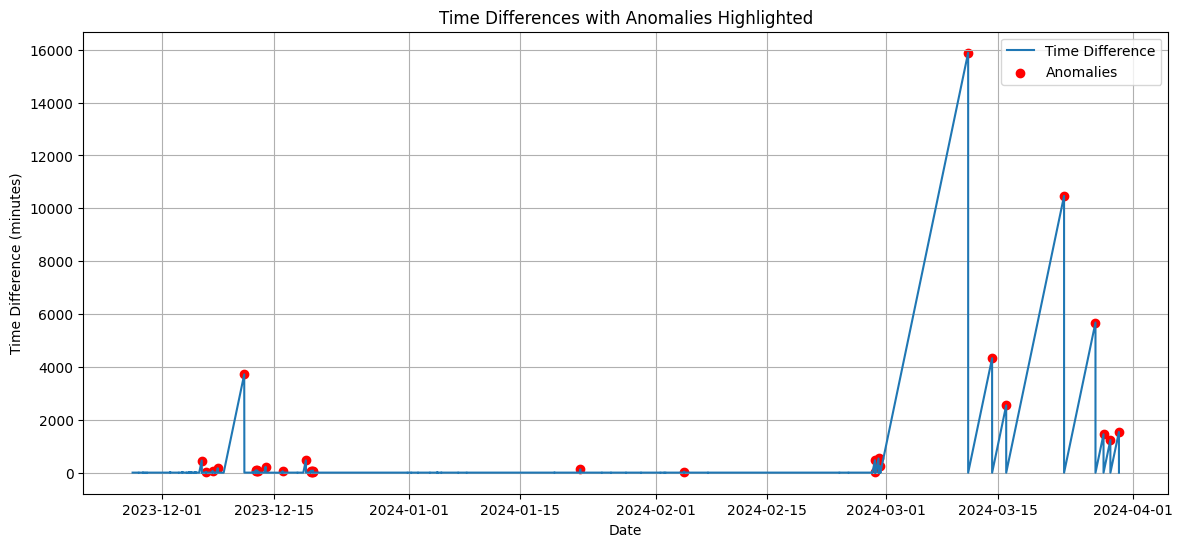

In [ ]:
import matplotlib.pyplot as plt

# Plotting anomalies over time
plt.figure(figsize=(14, 6))
plt.plot(df_cleaned['date'], df_cleaned['time_difference_minutes'], label='Time Difference')
plt.scatter(anomalies['date'], anomalies['time_difference_minutes'], color='red', label='Anomalies')
plt.xlabel('Date')
plt.ylabel('Time Difference (minutes)')
plt.title('Time Differences with Anomalies Highlighted')
plt.legend()
plt.grid()
plt.show()


***1.6.8 Analyzing anamoly trends***

In [ ]:
# Analyze anomaly dates for trends
anomaly_dates = anomalies['date'].dt.date.value_counts()
print(anomaly_dates)


date
2023-12-19    7
2023-12-12    5
2023-12-07    2
2024-02-28    2
2024-02-29    2
2023-12-11    1
2023-12-05    1
2023-12-06    1
2023-12-16    1
2023-12-13    1
2024-02-04    1
2024-01-22    1
2024-03-11    1
2024-03-14    1
2024-03-16    1
2024-03-23    1
2024-03-27    1
2024-03-28    1
2024-03-29    1
2024-03-30    1
Name: count, dtype: int64


**1.7 Further exploration and cleaning of the data based on other features**

***1.7.1 Imputation of temperature and humidity data:***

In [ ]:
# Impute missing time gaps using linear interpolation
df_cleaned['tempreature'] = df_cleaned['tempreature'].interpolate(method='linear')
df_cleaned['humidity'] = df_cleaned['humidity'].interpolate(method='linear')


***1.7.2 Add hour and day of week***

In [ ]:
df_cleaned['hour'] = pd.to_datetime(df_cleaned['date']).dt.hour
df_cleaned['day_of_week'] = pd.to_datetime(df_cleaned['date']).dt.dayofweek


***1.7.3 Grouping anamolies by month for exploring***

In [ ]:
# Grouping of anomalies by month
anomalies = anomalies.copy()
anomalies['month'] = pd.to_datetime(anomalies['date']).dt.to_period('M')
monthly_anomalies = anomalies.groupby('month')['time_difference_minutes'].count()

# Display anomalies per month
print(monthly_anomalies)

month
2023-12    19
2024-01     1
2024-02     5
2024-03     8
Freq: M, Name: time_difference_minutes, dtype: int64


***1.7.4. Check for missing values in the dataset***

In [ ]:
# Check for missing values in the dataset
print(df_cleaned.isnull().sum())

# If there are still missing values, you can drop or impute them
df_cleaned = df_cleaned.dropna()  # Or use fillna() for specific columns

date                       0
tempreature                0
humidity                   0
water_level                0
N                          0
P                          0
K                          0
Fan_actuator_OFF           0
Fan_actuator_ON            0
Watering_plant_pump_OFF    0
Watering_plant_pump_ON     0
Water_pump_actuator_OFF    0
Water_pump_actuator_ON     0
unix_timestamp             0
time_difference_seconds    0
time_difference_minutes    1
anomaly_flag               0
hour                       0
day_of_week                0
dtype: int64


***1.7.5 Summary statistics of features and visualization of temperature and humidity distribution***

In [ ]:
# Summary statistics for numerical columns
print(df_cleaned.describe())

                                date  tempreature    humidity  water_level  \
count                          28681  28681.00000 28681.00000  28681.00000   
mean   2024-01-13 20:44:24.315051520     17.75109    57.60434     88.11258   
min              2023-11-27 06:31:00      3.00000     0.00000      0.00000   
25%              2023-12-24 22:47:00     13.00000    57.00000    100.00000   
50%              2024-01-14 03:25:00     16.00000    60.00000    100.00000   
75%              2024-02-03 16:00:00     22.00000    64.00000    100.00000   
max              2024-03-30 05:24:00     41.00000   100.00000    100.00000   
std                              NaN      6.79532    15.89504     28.00708   

                N           P           K  Fan_actuator_OFF  Fan_actuator_ON  \
count 28681.00000 28681.00000 28681.00000       28681.00000      28681.00000   
mean    227.37412   229.95806   219.20376           0.75018          0.24982   
min       0.00000     0.00000     0.00000           0.000

***1.7.6 Visualizing the distribution of Temperature and Humidity***

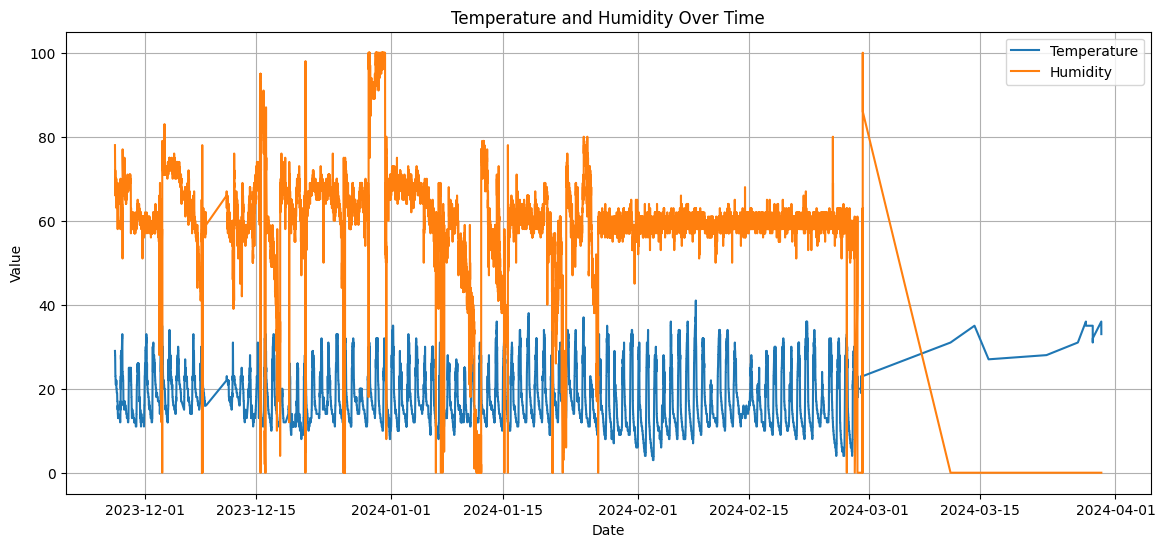

In [ ]:
# Plot temperature and humidity over time
plt.figure(figsize=(14, 6))
plt.plot(df_cleaned['date'], df_cleaned['tempreature'], label='Temperature')
plt.plot(df_cleaned['date'], df_cleaned['humidity'], label='Humidity')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Temperature and Humidity Over Time')
plt.legend()
plt.grid()
plt.show()

***1.7.7 Further visualization of trend seasonality and Resid in Temperature***

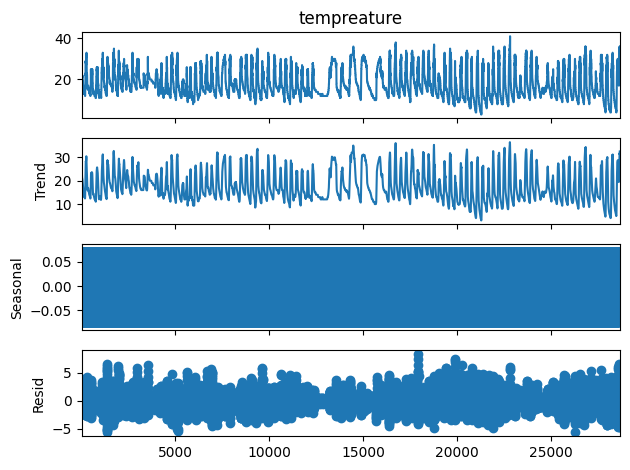

<Figure size 1200x600 with 0 Axes>

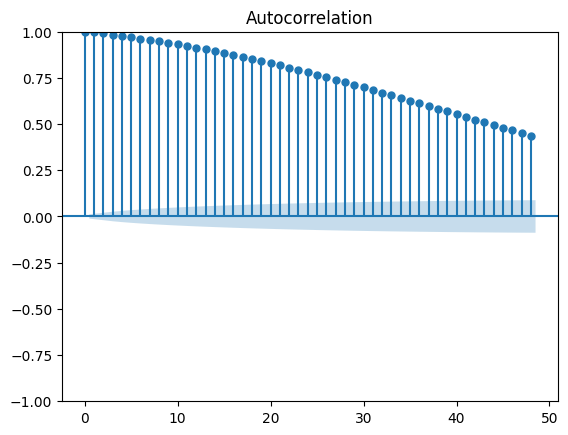

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series (e.g., for temperature)
decomposition = seasonal_decompose(df_cleaned['tempreature'], model='additive', period=24)  # Assuming hourly data with daily seasonality

# Plot the decomposition
decomposition.plot()
plt.show()

# Autocorrelation plot
plt.figure(figsize=(12, 6))
plot_acf(df_cleaned['tempreature'], lags=48)  # Check up to 48 hours (2 days) of lags
plt.show()

***1.7.7 Adding derived features that may help modelling***

In [ ]:
# Create a fresh copy of df_cleaned to ensure we're working with a new DataFrame
df_cleaned = df_cleaned.copy()

# Add month and year using .loc to avoid warnings
df_cleaned.loc[:, 'month'] = pd.to_datetime(df_cleaned['date']).dt.month
df_cleaned.loc[:, 'year'] = pd.to_datetime(df_cleaned['date']).dt.year

# Add lag features using .loc
df_cleaned.loc[:, 'tempreature_lag1'] = df_cleaned['tempreature'].shift(1)
df_cleaned.loc[:, 'humidity_lag1'] = df_cleaned['humidity'].shift(1)

# Drop any new NaN values created by shifting
df_cleaned = df_cleaned.dropna()

# Verify the changes
print(df_cleaned.head())

                 date  tempreature  humidity  water_level    N    P    K  \
2 2023-11-27 06:36:00           28        77          100  185  190  160   
3 2023-11-27 06:41:00           28        75          100  185  190  160   
4 2023-11-27 06:46:00           28        74          100  185  190  160   
5 2023-11-27 06:51:00           28        75          100  185  190  160   
6 2023-11-27 06:56:00           28        74          100  185  190  160   

   Fan_actuator_OFF  Fan_actuator_ON  Watering_plant_pump_OFF  ...  \
2           0.00000          1.00000                  1.00000  ...   
3           0.00000          1.00000                  1.00000  ...   
4           0.00000          1.00000                  1.00000  ...   
5           0.00000          1.00000                  1.00000  ...   
6           0.00000          1.00000                  1.00000  ...   

   unix_timestamp  time_difference_seconds  time_difference_minutes  \
2      1701066960                300.00000         

***1.7.8. Again visualization of Box Plots of Temperature and Humidity***

<ipython-input-184-c7566f000993>:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df_cleaned['tempreature'], df_cleaned['humidity']], labels=['Temperature', 'Humidity'])


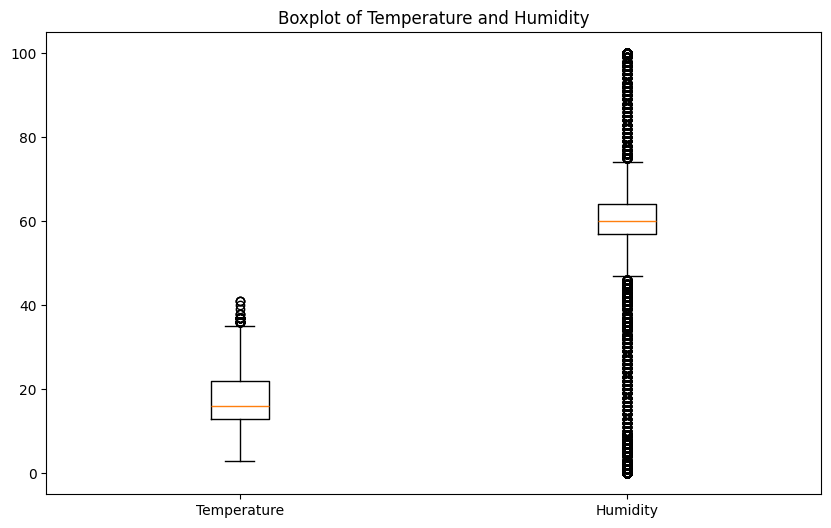

In [ ]:
plt.figure(figsize=(10, 6))
plt.boxplot([df_cleaned['tempreature'], df_cleaned['humidity']], labels=['Temperature', 'Humidity'])
plt.title('Boxplot of Temperature and Humidity')
plt.show()

**Observations**
- ***Boxplot of Temperature and Humidity***

- Temperature: The boxplot shows a median around 15–20°C, with whiskers extending from about 5°C to 40°C. There are a few outliers above 40°C and below 5°C, which could indicate sensor errors, extreme environmental conditions, or data entry issues. We need to investigate these outliers further to decide whether to remove, cap, or impute them.

- Humidity: The boxplot shows extreme variability, with outliers reaching 100% and possibly below 0% (though not visible in the plot). The median is around 60%, but the long whiskers and outliers suggest potential data quality issues or natural variability. We need to check the dates and contexts of these extreme values (e.g., 0% or 100% humidity might indicate sensor failure or missing data).

***1.7.8 Calculating ADF and p-value***

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Test for stationarity (temperature)
result = adfuller(df_cleaned['tempreature'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -17.66416971885477
p-value: 3.670272330810908e-30


**Observations**

Since the p-value is much less than 0.05, we reject the null hypothesis of the ADF test, indicating that tempreature is stationary. This is great news for time series modeling, as stationary data doesn’t require differencing (though we might still want to check for trends or seasonality visually).

***1.7.9 Corelation analysis***

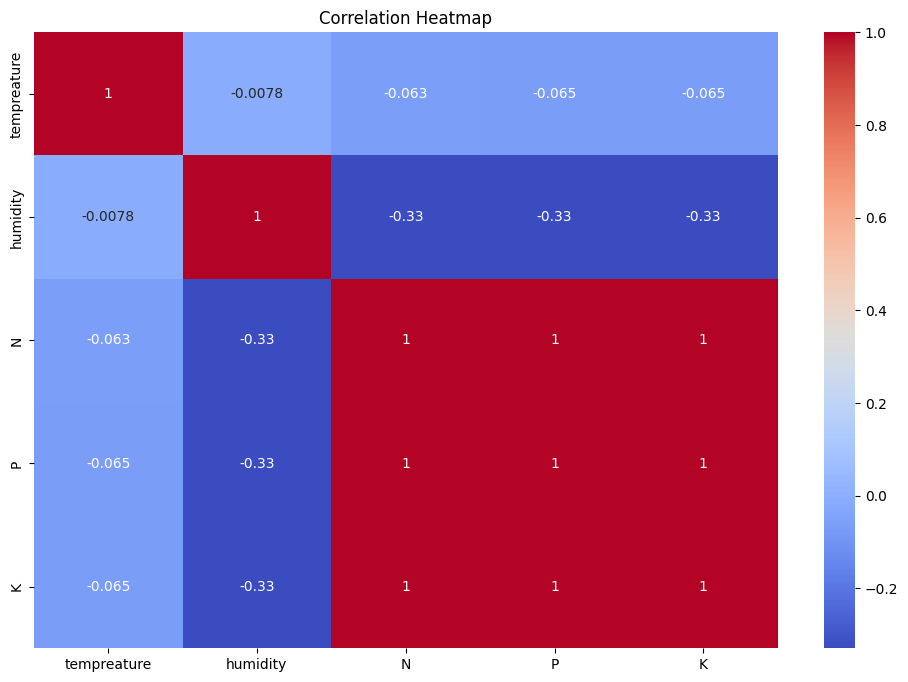

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_cleaned[['tempreature', 'humidity', 'N', 'P', 'K']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

**Observations**

- ***Temperature and Humidity:*** There’s a very weak negative correlation (-0.078) between tempreature and humidity, indicating they don’t strongly influence each other in the dataset.

- ***Nutrient Levels (N, P, K):*** These variables (N, P, K) are perfectly correlated with each other (correlation = 1), which suggests they might be redundant or measured together in a way that doesn’t vary independently. We may need to keep only one (e.g., N) or use dimensionality reduction (e.g., PCA) if we plan to use them in modeling.

- ***Temperature and Nutrients:*** There’s a moderate negative correlation (-0.33) between tempreature and N, P, K, indicating that higher temperatures might be associated with lower nutrient levels (or vice versa). This could be meaningful for the analysis.

- ***Humidity and Nutrients:*** A similar moderate negative correlation (-0.33) exists between humidity and N, P, K, suggesting a potential relationship worth exploring.


***1.7.10. Seeing outliers through IQRs***

In [ ]:
# Ensure df_cleaned is a fresh copy to avoid warnings
df_cleaned = df_cleaned.copy()

# Calculate IQR for temperature and humidity
Q1_temp = df_cleaned['tempreature'].quantile(0.25)
Q3_temp = df_cleaned['tempreature'].quantile(0.75)
IQR_temp = Q3_temp - Q1_temp

Q1_hum = df_cleaned['humidity'].quantile(0.25)
Q3_hum = df_cleaned['humidity'].quantile(0.75)
IQR_hum = Q3_hum - Q1_hum

# Define outlier thresholds
lower_bound_temp = Q1_temp - 1.5 * IQR_temp
upper_bound_temp = Q3_temp + 1.5 * IQR_temp

lower_bound_hum = Q1_hum - 1.5 * IQR_hum
upper_bound_hum = Q3_hum + 1.5 * IQR_hum

# Identify outliers ( for inspection)
outliers_temp = df_cleaned[(df_cleaned['tempreature'] < lower_bound_temp) | (df_cleaned['tempreature'] > upper_bound_temp)]
outliers_hum = df_cleaned[(df_cleaned['humidity'] < lower_bound_hum) | (df_cleaned['humidity'] > upper_bound_hum)]

print("Temperature Outliers:")
print(outliers_temp[['date', 'tempreature']].head())
print("\nHumidity Outliers:")
print(outliers_hum[['date', 'humidity']].head())

# Cap outliers 
df_cleaned.loc[:, 'tempreature'] = df_cleaned['tempreature'].clip(lower_bound_temp, upper_bound_temp)
df_cleaned.loc[:, 'humidity'] = df_cleaned['humidity'].clip(lower_bound_hum, upper_bound_hum)

# Verify the changes
print("\nSummary after capping outliers:")
print(df_cleaned[['tempreature', 'humidity']].describe())

Temperature Outliers:
Empty DataFrame
Columns: [date, tempreature]
Index: []

Humidity Outliers:
                   date  humidity
4   2023-11-27 06:46:00        74
6   2023-11-27 06:56:00        74
281 2023-11-28 05:56:00        74
283 2023-11-28 06:06:00        74
284 2023-11-28 06:11:00        74

Summary after capping outliers:
       tempreature    humidity
count  24274.00000 24274.00000
mean      17.54849    61.09310
std        6.68115     4.97231
min        3.00000    49.00000
25%       13.00000    58.00000
50%       16.00000    60.00000
75%       22.00000    64.00000
max       35.00000    73.00000


***1.7.11 Inspectin outlier data***

In [ ]:
# Print a larger sample of outliers for inspection
print("Temperature Outliers (first 10 rows):")
print(outliers_temp[['date', 'tempreature']].head(10))
print("\nHumidity Outliers (first 10 rows):")
print(outliers_hum[['date', 'humidity']].head(10))

# Check if outliers correspond to specific time periods or patterns
print("\nOutliers by date (count):")
print(outliers_temp['date'].dt.date.value_counts().head(10))

Temperature Outliers (first 10 rows):
Empty DataFrame
Columns: [date, tempreature]
Index: []

Humidity Outliers (first 10 rows):
                    date  humidity
4    2023-11-27 06:46:00        74
6    2023-11-27 06:56:00        74
281  2023-11-28 05:56:00        74
283  2023-11-28 06:06:00        74
284  2023-11-28 06:11:00        74
1628 2023-12-02 21:24:00        47
1736 2023-12-03 05:39:00        74
1738 2023-12-03 05:49:00        74
1932 2023-12-03 22:04:00        74
1933 2023-12-03 22:09:00        74

Outliers by date (count):
Series([], Name: count, dtype: int64)


Humidity IQR Thresholds:
Q1: 58.0, Q3: 64.0, IQR: 6.0
Lower Bound: 49.0, Upper Bound: 73.0

All Humidity Outliers (first 10 rows):
Empty DataFrame
Columns: [date, humidity]
Index: []

Total Humidity Outliers: 0


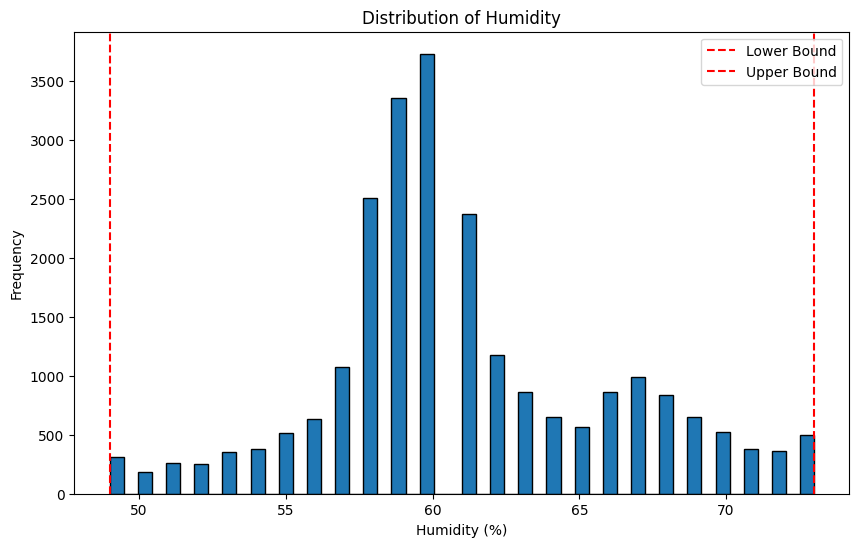

In [ ]:
# Ensure df_cleaned is a fresh copy
df_cleaned = df_cleaned.copy()

# Calculate IQR for humidity again
Q1_hum = df_cleaned['humidity'].quantile(0.25)
Q3_hum = df_cleaned['humidity'].quantile(0.75)
IQR_hum = Q3_hum - Q1_hum

# Define outlier thresholds
lower_bound_hum = Q1_hum - 1.5 * IQR_hum
upper_bound_hum = Q3_hum + 1.5 * IQR_hum

# Print the thresholds for inspection
print("Humidity IQR Thresholds:")
print(f"Q1: {Q1_hum}, Q3: {Q3_hum}, IQR: {IQR_hum}")
print(f"Lower Bound: {lower_bound_hum}, Upper Bound: {upper_bound_hum}")

# Identify and print all humidity outliers
outliers_hum = df_cleaned[(df_cleaned['humidity'] < lower_bound_hum) | (df_cleaned['humidity'] > upper_bound_hum)]
print("\nAll Humidity Outliers (first 10 rows):")
print(outliers_hum[['date', 'humidity']].head(10))
print(f"\nTotal Humidity Outliers: {len(outliers_hum)}")

# Visualize the distribution of humidity to understand its spread
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df_cleaned['humidity'], bins=50, edgecolor='black')
plt.axvline(lower_bound_hum, color='red', linestyle='--', label='Lower Bound')
plt.axvline(upper_bound_hum, color='red', linestyle='--', label='Upper Bound')
plt.title('Distribution of Humidity')
plt.xlabel('Humidity (%)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

**Observations**
1. ***Humidity Distribution Plot***

The histogram shows the distribution of humidity values, with a peak around 60–65%, indicating that most of the humidity measurements fall in this range. The distribution tapers off toward the lower (below 50%) and upper (above 70%) ends, but there are no significant spikes at extreme values (e.g., 0% or 100%), which suggests the data cleaning steps (e.g., handling anomalies, interpolating missing values) have already addressed those extremes.

The red dashed lines indicate the IQR-based outlier thresholds:
    ***- Lower Bound: 49%***
    ***- Upper Bound: 73%***

The fact that the distribution shows values below 49% and above 73% but they’re not numerous suggests these are either rare but valid measurements or residual outliers from earlier data issues.

2. ***IQR Thresholds and Outliers***

***Thresholds:***
    ***- Q1 (25th percentile): 58%***
    ***- Q3 (75th percentile): 64%***
    ***- IQR: 6%***
    ***- Lower Bound: 49% (58% - 1.5 * 6%)***
    ***-Upper Bound: 73% (64% + 1.5 * 6%)***

***Outliers:*** We now have 0 humidity and temperature outliers. This is a positive outcome, indicating that the data is now clean and within a reasonable range for humidity (49%–73%), with no extreme outliers like 0% or 100%.

***1.7.12 Verify Data Integrity***

In [ ]:
# Check for missing values
print(df_cleaned.isnull().sum())

# Ensure chronological order and no duplicate timestamps
print(df_cleaned['unix_timestamp'].is_monotonic_increasing)
df_cleaned = df_cleaned.drop_duplicates(subset=['unix_timestamp'], keep='first')

# Verify the range of temperature and humidity
print("\nTemperature Range:")
print(df_cleaned['tempreature'].describe())
print("\nHumidity Range:")
print(df_cleaned['humidity'].describe())

date                       0
tempreature                0
humidity                   0
water_level                0
N                          0
P                          0
K                          0
Fan_actuator_OFF           0
Fan_actuator_ON            0
Watering_plant_pump_OFF    0
Watering_plant_pump_ON     0
Water_pump_actuator_OFF    0
Water_pump_actuator_ON     0
unix_timestamp             0
time_difference_seconds    0
time_difference_minutes    0
anomaly_flag               0
hour                       0
day_of_week                0
month                      0
year                       0
tempreature_lag1           0
humidity_lag1              0
weekday                    0
dtype: int64
True

Temperature Range:
count   24274.00000
mean       17.54849
std         6.68115
min         3.00000
25%        13.00000
50%        16.00000
75%        22.00000
max        35.00000
Name: tempreature, dtype: float64

Humidity Range:
count   24274.00000
mean       61.09310
std         4.9

**Obaservations**

No null values, duplicates or outliers. Good to go for final data preparation

## Section -2: Final data preparation for modelling

**2.1 Final preparation of the file for modelling**

In [ ]:
# Ensure df_cleaned is a fresh copy
df_cleaned = df_cleaned.copy()

# Create combined binary features for actuators and pumps
df_cleaned['Fan_actuator'] = df_cleaned['Fan_actuator_ON'].apply(lambda x: 1 if x == 1 else 0)
df_cleaned['Watering_plant_pump'] = df_cleaned['Watering_plant_pump_ON'].apply(lambda x: 1 if x == 1 else 0)
df_cleaned['Water_pump_actuator'] = df_cleaned['Water_pump_actuator_ON'].apply(lambda x: 1 if x == 1 else 0)

# Select the recommended columns (keeping only N, not P or K, to avoid redundancy)
selected_columns = [
    'date', 'unix_timestamp', 'tempreature', 'humidity', 'hour', 'day_of_week',
    'month', 'year', 'tempreature_lag1', 'humidity_lag1', 'N', 'Fan_actuator',
    'Watering_plant_pump', 'Water_pump_actuator', 'water_level', 'time_difference_minutes'
]

# Create the final DataFrame with selected columns
df_final = df_cleaned[selected_columns]

# Verify the DataFrame
print(df_final.head())
print("\nColumn Count:", len(df_final.columns))

# Check for missing values or duplicates
print("\nMissing Values:")
print(df_final.isnull().sum())
print("\nDuplicates in unix_timestamp:", df_final.duplicated(subset=['unix_timestamp']).sum())

# Ensure chronological order
df_final = df_final.sort_values(by='unix_timestamp').reset_index(drop=True)
print("\nIs chronological:", df_final['unix_timestamp'].is_monotonic_increasing)

# Export to CSV
df_final.to_csv('prepared_iot_data.csv', index=False)

print("Data preparation complete. Dataset exported to 'prepared_iot_data.csv'")

                 date  unix_timestamp  tempreature  humidity  hour  \
4 2023-11-27 06:46:00      1701067560           28        73     6   
6 2023-11-27 06:56:00      1701068160           28        73     6   
7 2023-11-27 07:01:00      1701068460           28        72     7   
8 2023-11-27 07:06:00      1701068760           27        71     7   
9 2023-11-27 07:11:00      1701069060           26        71     7   

   day_of_week  month  year  tempreature_lag1  humidity_lag1    N  \
4            0     11  2023          28.00000       75.00000  185   
6            0     11  2023          28.00000       75.00000  185   
7            0     11  2023          28.00000       74.00000  185   
8            0     11  2023          28.00000       72.00000  185   
9            0     11  2023          27.00000       71.00000  185   

   Fan_actuator  Watering_plant_pump  Water_pump_actuator  water_level  \
4             1                    0                    0          100   
6             1 

**Notes on Column Selection**

**Columns to keep**

***- Time based features:*** Focus on date, tempreature, humidity, and lagged features (tempreature_lag1, humidity_lag1). Time-based features (hour, day_of_week, month) help capture seasonality. If time_difference_minutes is irregular, we might need to resample the data to regular intervals (e.g., hourly) before modeling.

- date: Essential for maintaining the chronological order and indexing the time series. This is critical for both time series models (e.g., ARIMA, Prophet) and deep learning models (e.g., LSTMs) that rely on temporal structure.
- unix_timestamp: Useful as a numerical representation of time for sorting, ensuring chronological order, and potentially as a feature in deep learning models. It’s redundant with date but can be helpful for computational purposes.
- hour: Captures hourly patterns (e.g., diurnal cycles), which are likely important for modeling temperature and humidity variations.
- day_of_week: Captures weekly patterns, which could influence environmental conditions (e.g., weekends vs. weekdays if human activity affects the environment).
- month: Captures monthly patterns, which might reflect seasonal trends (e.g., temperature and humidity changes over late 2023 to early 2024).

***Target Variables:***
- temperature: The primary target variable for prediction, especially for time series modeling.
- humidity: Another potential target variable or feature, depending on whether you’re modeling it independently or alongside temperature.

***Lagged Features:***
- tempreature_lag1: The temperature from the previous time step, which is critical for capturing temporal dependencies in time series and deep learning models.
-humidity_lag1: The humidity from the previous time step, similarly useful for modeling temporal relationships.

***Environmental/Operational Features***
- N, P, K: These represent nutrient levels (likely related to soil or plant health in an IoT agricultural context). They show perfect correlation (1.0) with each other in the correlation heatmap, suggesting redundancy. We can keep just one (e.g., N) to avoid multicollinearity, or use dimensionality reduction (e.g., PCA) if we plan to use them in modeling. These could be relevant if they influence temperature or humidity (e.g., via plant transpiration or irrigation).
- Fan_actuator_OFF, Fan_actuator_ON: Indicate fan operation, which could affect temperature and humidity (e.g., ventilation cooling or drying). We might combine these into a single binary feature (Fan_actuator = 1 if Fan_actuator_ON = 1, else 0) to simplify, as they’re mutually exclusive.
- Watering_plant_pump_OFF, Watering_plant_pump_ON: Indicate irrigation activity, which could influence humidity (e.g., through water evaporation). Similarly, combine into a single binary feature (Watering_plant_pump = 1 if Watering_plant_pump_ON = 1, else 0).
- Water_pump_actuator_OFF, Water_pump_actuator_ON: Another indicator of water-related activity, potentially affecting humidity. Combine into a single binary feature (Water_pump_actuator = 1 if Water_pump_actuator_ON = 1, else 0).
- water_level: Represents water availability, which could indirectly affect humidity (e.g., through irrigation). This could be a useful feature if it correlates the targets

**Deep Learning Models:** Include all numerical and categorical features (e.g., N, Fan_actuator, Watering_plant_pump) after normalization. Lagged features and time-based variables are critical for capturing temporal dependencies.

**Redundancy:** Dropping P and K (keeping only N) avoids multicollinearity, but we can include all three if we plan to use dimensionality reduction techniques later.

**Optional Columns:** The time_difference_minutes is consistently small (e.g., 5 minutes, as seen in the sample data), we might drop it to simplify the dataset, assuming the data is regularly sampled.

***2.2. Checking the heatmap of time differences between day of the week and hour.***

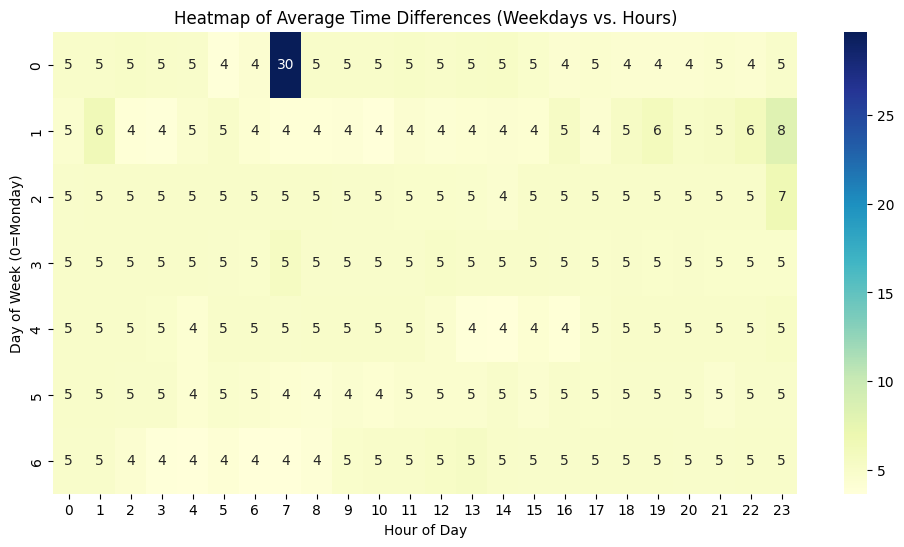

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create hour and weekday features
df_cleaned['hour'] = pd.to_datetime(df_cleaned['date']).dt.hour
df_cleaned['weekday'] = pd.to_datetime(df_cleaned['date']).dt.dayofweek

# Pivot for heatmap
heatmap_data = df_cleaned.pivot_table(index='weekday', columns='hour', values='time_difference_minutes', aggfunc='mean')

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt=".0f")
plt.title('Heatmap of Average Time Differences (Weekdays vs. Hours)')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week (0=Monday)')
plt.show()


**Observations**

The heatmap represents the average time differences (in minutes) across different hours of the day and days of the week. Here's an interpretation of the key insights:

***- General Trend:*** Most values across the heatmap are around 4-6 minutes, indicating a relatively stable time difference across the week.

***- Significant Outlier:***

On Monday (0th day) at the 7th hour (7 AM), there's a spike to 30 minutes. This suggests that something unusual happens at this specific time—perhaps a system delay, traffic congestion, or another factor influencing the data.

***- Minor Variations:***

- Some cells have slightly higher values (e.g., 6-8 minutes on certain days), but nothing as extreme as the outlier at 7 AM on Monday.
- Tuesday (2nd day) at 23rd hour (11 PM) shows a value of 7 minutes, which is slightly higher than the baseline.

***Late Night and Early Morning Consistency:***

- Most late-night (midnight to early morning) values hover around 4-5 minutes, suggesting stability in that timeframe.

The observations sugges that we are good to go with the modelling